# Settings

In [1]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
os.chdir('..'+sep_local+'..'+sep_local+'..')
print(os.getcwd())

C:\Users\Khalid\Documents\projects\GM\Generative_Models


# Dataset loading

In [4]:
dataset_name='pokemon'

In [5]:
IMG_DIR = 'C:\\Users\\Khalid\\Documents\projects\\pokemon\DS06\\'
VAL_PCT = 20
VAL_FORMAT = 'png'

In [6]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [7]:
imgs_list = create_image_lists(
    image_dir=IMG_DIR, 
    validation_pct=VAL_PCT, 
    valid_imgae_formats=VAL_FORMAT
)

  DEBUG    | Looking for images in 'all'


  INFO     | 809 file found


In [8]:
inputs_shape= IMG_SIZE=(200, 200, 3)
batch_size = 32
latent_dim = 32
intermediate_dim = 32

In [9]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=IMG_DIR, 
    image_size=IMG_SIZE, 
    batch_size=batch_size, 
    class_mode=None
)

  INFO     | Found 662 training files


  INFO     | Found 147 validation files


In [10]:
import tensorflow as tf

In [11]:
import random
import numpy as np
from utils.augmentation.augmentor import operations, do_operation
def batch_augmentor(batch, operation=None):
    if operation is None:
        rn = random.randint(0, len(operations)-1)
        #print(operations[rn]())
        operation = operations[rn]()
    return batch, np.array([do_operation(operation, image) for image in batch])

def generator_augmentor(generator): 
    while True:
        yield batch_augmentor(next(generator))

In [12]:
batch, aug_batch = next(generator_augmentor(train_gen))

In [13]:
import matplotlib.pyplot as plt

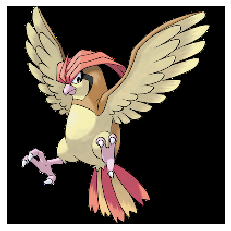

In [14]:
plt.imshow(batch[2])
plt.axis('off');
plt.show()

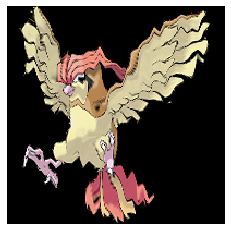

In [15]:
plt.imshow(aug_batch[2])
plt.axis('off');
plt.show()

In [16]:
train_ds = tf.data.Dataset.from_generator(
    lambda: generator_augmentor(train_gen), 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((batch_size, ) + IMG_SIZE), tf.TensorShape((batch_size, ) + IMG_SIZE))
)

test_ds = tf.data.Dataset.from_generator(
    lambda: generator_augmentor(test_gen), 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((batch_size, ) + IMG_SIZE), tf.TensorShape((batch_size, ) + IMG_SIZE))
)


In [13]:
_instance_scale=1.0
for data in generator_augmentor(train_gen):
    _instance_scale = float(data[0].max())
    break

In [14]:
_instance_scale

1.0

In [15]:
import numpy as np
from collections.abc import Iterable

In [16]:
if isinstance(inputs_shape, Iterable):
    _outputs_shape = np.prod(inputs_shape)

In [17]:
_outputs_shape

120000

# Model's Layers definition

In [18]:
enc_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=latent_dim)]

dec_lays = [tf.keras.layers.Dense(units=latent_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=_outputs_shape),
            tf.keras.layers.Reshape(inputs_shape)]

# Model definition

In [22]:
model_name = dataset_name+'_augmented_TAE_Dense_reconst_ell'
experiments_dir='experiments'+sep_local+model_name

In [23]:
from training.autoencoding_basic.transformative.AE import autoencoder as AE

In [24]:
inputs_shape=IMG_SIZE

In [25]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_lays
    }

    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [26]:
from utils.data_and_files.file_utils import create_if_not_exist

In [27]:
_restore = os.path.join(experiments_dir, 'var_save_dir')

In [28]:
create_if_not_exist(_restore)
_restore

'recording\\pokemon_augmented_TAE_Dense_reconst_ell\\var_save_dir'

In [29]:
#to restore trained model, set filepath=_restore

In [30]:
ae = AE( 
    name=model_name,
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    batch_size=batch_size,
    variables_params=variables_params, 
    filepath=_restore
    )

  DEBUG    | Restore old models ...


Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 200, 200, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 200, 200, 32)      128       
_________________________________________________________________
dense_1 (Dense)              (None, 200, 200, 32)      1056      
_________________________________________________________________
flatten (Flatten)            (None, 1280000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                40960032  
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0 

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generative_inputs (InputLaye [(None, 32)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 120000)            3960000   
_________________________________________________________________
reshape (Reshape)            (None, 200, 200, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 3)       12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200, 3)       0

  WARNING  | None


In [32]:
#ae.compile(metrics=None)
ae.compile()

Model: "pokemon_augmented_TAE_Dense_reconst_ell"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 200, 200, 3)]     0         
_________________________________________________________________
inference (Model)            (None, 32)                40961344  
_________________________________________________________________
generative (Model)           (None, 200, 200, 3)       3962124   
_________________________________________________________________
tf_op_layer_x_logits (Tensor [(None, 200, 200, 3)]     0         
Total params: 44,923,468
Trainable params: 44,923,398
Non-trainable params: 70
_________________________________________________________________
None


# Callbacks

In [33]:
from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [34]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

In [35]:
ms = ModelSaver(filepath=_restore,save_freq=5)

In [36]:
csv_dir = os.path.join(experiments_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, ae.name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
csv_dir

'experiments\\pokemon_augmented_TAE_Dense_reconst_ell\\csv_dir\\pokemon_augmented_TAE_Dense_reconst_ell.csv'

In [37]:
image_gen_dir = os.path.join(experiments_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)

In [38]:
sg = SampleGeneration(latent_shape=latent_dim, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=False)

In [39]:
import numpy as np

# Model Training

In [40]:
ae.fit(
    x=train_ds,
    input_kw=None,
    steps_per_epoch=1000,
    epochs=int(1e6), 
    verbose=2,
    callbacks=[ es, ms, csv_log, sg],
    workers=-1,
    use_multiprocessing=True,
    validation_data=test_ds,
    validation_steps=1000
)

Train for 1000 steps, validate for 1000 steps
Epoch 1/1000000
1000/1000 - 489s - loss: 305912.4831 - psnr: 8.6773 - ssmi: 0.0040 - sharpdiff: 4.2285 - val_loss: 259287.5852 - val_psnr: 9.7727 - val_ssmi: 0.5290 - val_sharpdiff: 13.1930
Epoch 2/1000000
1000/1000 - 480s - loss: 279705.6616 - psnr: 8.6480 - ssmi: 0.0040 - sharpdiff: 4.2275 - val_loss: 218774.0607 - val_psnr: 9.8108 - val_ssmi: 0.5349 - val_sharpdiff: 13.1821
Epoch 3/1000000
1000/1000 - 483s - loss: 244985.9972 - psnr: 8.6422 - ssmi: 0.0040 - sharpdiff: 4.2293 - val_loss: 195115.7465 - val_psnr: 9.7479 - val_ssmi: 0.5324 - val_sharpdiff: 13.2855
Epoch 4/1000000
1000/1000 - 481s - loss: 207801.1633 - psnr: 8.6633 - ssmi: 0.0041 - sharpdiff: 4.2307 - val_loss: 170286.9128 - val_psnr: 9.8328 - val_ssmi: 0.5259 - val_sharpdiff: 13.0827
Epoch 5/1000000
1000/1000 - 483s - loss: 169166.7696 - psnr: 8.7293 - ssmi: 0.0045 - sharpdiff: 4.2520 - val_loss: 137466.5983 - val_psnr: 9.9800 - val_ssmi: 0.5223 - val_sharpdiff: 13.0871
Epoc

Epoch 44/1000000
1000/1000 - 493s - loss: 34733.7827 - psnr: 10.3457 - ssmi: 0.0413 - sharpdiff: 5.7293 - val_loss: 26539.3330 - val_psnr: 12.1932 - val_ssmi: 0.1323 - val_sharpdiff: 12.3382
Epoch 45/1000000
1000/1000 - 491s - loss: 34766.7598 - psnr: 10.3287 - ssmi: 0.0403 - sharpdiff: 5.7139 - val_loss: 26687.2782 - val_psnr: 12.1813 - val_ssmi: 0.1317 - val_sharpdiff: 12.2904
Epoch 46/1000000
1000/1000 - 488s - loss: 34631.6784 - psnr: 10.3437 - ssmi: 0.0415 - sharpdiff: 5.7347 - val_loss: 25981.8566 - val_psnr: 12.3102 - val_ssmi: 0.1255 - val_sharpdiff: 12.3186
Epoch 47/1000000
1000/1000 - 489s - loss: 34332.9363 - psnr: 10.3751 - ssmi: 0.0427 - sharpdiff: 5.7452 - val_loss: 25558.0156 - val_psnr: 12.3745 - val_ssmi: 0.1300 - val_sharpdiff: 12.4087
Epoch 48/1000000
1000/1000 - 490s - loss: 34596.4481 - psnr: 10.3612 - ssmi: 0.0427 - sharpdiff: 5.7621 - val_loss: 25788.5497 - val_psnr: 12.3378 - val_ssmi: 0.1315 - val_sharpdiff: 12.3072
Epoch 49/1000000
1000/1000 - 485s - loss: 346

In [161]:
import numpy as np
mean_fn = lambda x: np.mean(x, axis=0)
sigma_fn = lambda x: np.cov(x, rowvar=False)

from tqdm import tqdm
def bootstrapping(data_generator, func, tolerance_threshold=1e-12):
    outputs = func(next(data_generator))
    
    for data in tqdm(data_generator):
        new_outputs = np.mean([func(data), outputs], axis=0)
        diff_outputs = np.absolute(outputs-new_outputs)
        outputs = new_outputs
        if all(diff_outputs<=tolerance_threshold):
            break
    return outputs

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

def frechet_inception_distance(model, data_generator):
    def calculate_fid(generated_mean, generated_sigma, inception_mean, inception_sigma):
        # calculate sum squared difference between means
        ssdiff = np.sum((generated_mean - inception_mean)**2.0)
        # calculate sqrt of product between cov
        covmean = np.sqrtm(sigma1.dot(inception_sigma))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(generated_sigma + inception_sigma - 2.0 * covmean)
        return fid
    
    # prepare the inception v3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=IMG_SIZE)
    inception_predictions = lambda x: inception_model.prediction(preprocess_input(x))
    def inception_predictions_generator():
        while True:
            data = next(data_generator)
            yield inception_predictions(data)

    # prepare the ae model random_images_generator
    def model_random_images_generator():
        while True:
            data = model.generate_random_images()
            yield inception_predictions(data)


    generated_images_mean = bootstrapping(data_generator=model_random_images_generator, func=mean_fn)
    generated_images_sigma = bootstrapping(data_generator=model_random_images_generator, func=sigma_fn)
    inception_images_mean = bootstrapping(data_generator=inception_predictions_generator, func=mean_fn)
    inception_images_sigma = bootstrapping(data_generator=inception_predictions_generator, func=mean_fn)
    
    return calculate_fid(generated_images_mean, generated_images_sigma, inception_images_mean, inception_images_sigma)

In [163]:
def inception_score(model):
    def calculate_is(x):
        kl = x * (np.log(x) - np.log(np.expand_dims(np.mean(x, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        return np.exp(kl)
    
    # prepare the inception v3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=IMG_SIZE)
    inception_predictions = lambda x: inception_model.prediction(preprocess_input(x))

    # prepare the ae model random_images_generator
    def model_random_images_generator():
        while True:
            data = model.generate_random_images()
            yield inception_predictions(data)

    is_mean  = bootstrapping(data_generator=model_random_images_generator, func=lambda x: mean_fn(calculate_is(x)))
    is_sigma = bootstrapping(data_generator=model_random_images_generator, func=sigma_fn(calculate_is(x)))
    
    return is_mean, is_sigma

In [ ]:
# Normalize batch of vectors.
def normalize(v):
    return v / tf.sqrt(tf.reduce_sum(tf.square(v), axis=-1, keepdims=True))

# Spherical interpolation of a batch of vectors.
def slerp(a, b, t):
    a = normalize(a)
    b = normalize(b)
    d = tf.reduce_sum(a * b, axis=-1, keepdims=True)
    p = t * tf.math.acos(d)
    c = normalize(b - d * a)
    d = a * tf.math.cos(p) + c * tf.math.sin(p)
    return normalize(d)

def perceptual_path_length():
    def calculate_ppl(x):
        
    return a, b    

In [168]:
batch_size=batch_size

In [169]:
# Generate random latents and interpolation t-values.
np.random.normal(size=[1 * 2] + [batch_size])
np.random.uniform(size=[1])

array([0.58554919])

In [170]:
np.random.normal(size=[1 * 2] + [batch_size])


array([[-0.23677475,  1.11606706,  0.77859805, -2.19208048,  0.58304818,
        -0.18892166,  0.36731411, -0.52119105,  0.73597746,  1.10893803,
        -0.77538077,  0.30355254, -0.3293459 , -0.00875247, -0.46784017,
         0.37284786, -0.07367586,  0.48750567, -0.24077998,  1.19072621,
         1.02363407,  1.05854533,  0.24251897, -0.27462903, -0.5173232 ,
         1.27956867,  0.6402143 ,  0.43400644, -1.10452971, -2.07058418,
         0.60566451,  0.69089328],
       [ 0.34875959,  1.48160089, -0.22782338, -1.00993023,  0.72371725,
        -0.27307251, -0.33637015, -0.60627038, -1.4098449 , -0.46015131,
        -0.55613967,  0.98347385,  0.63679137,  0.27481399,  0.04436604,
        -0.30056939, -1.07433739, -0.36976892,  0.47973275,  1.84391868,
        -0.03110368, -2.31670744, -0.99977034,  0.10631642,  0.38336735,
         1.25699866,  1.64797833, -0.99134237, -0.49544532,  1.12160482,
        -0.51423488, -1.53245078]])

In [ ]:
latent_t01 = tf.random_normal([1 * 2] + [batch_size] )
lerp_t = tf.random_uniform([1], 0.0, 1.0 if self.sampling == 'full' else 0.0)

In [ ]:

# space == 'z'
lat_t0, lat_t1 = lat_t01[0::2], lat_t01[1::2]
lat_e0 = slerp(lat_t0, lat_t1, lerp_t[:, np.newaxis])
lat_e1 = slerp(lat_t0, lat_t1, lerp_t[:, np.newaxis] + self.epsilon)
lat_e01 = tf.reshape(tf.stack([lat_e0, lat_e1], axis=1), lat_t01.shape)
dlat_e01 = Gs_clone.components.mapping.get_output_for(lat_e01, None, is_validation=True)

In [33]:
z_mean, z_std = np.zeros((latent_dim,)), np.zeros((latent_dim,))
tolerance_threshold=1e-12

In [34]:
for i, batch in enumerate(train_gen):
    z_latent = ae.encode(inputs= {'inputs': batch})['z_latent']
    batch_z_mean, batch_z_std = np.mean(z_latent, axis=1), np.std(z_latent, axis=1)
    new_z_mean, new_z_std = np.mean([z_mean, batch_z_mean], axis=0), np.mean([z_std, batch_z_std], axis=0)
    diff_std = np.absolute(z_std-new_z_std)
    z_mean, z_std = new_z_mean, new_z_std
    if all(diff_std<=0.1):
        print(f'batch number {i}')
        break


batch number 209


In [ ]:
# pre-process images
images1 = preprocess_input(images1)

In [ ]:
def calculate_activation_statistics(images, sess, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean